In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch

_download_ = False
folder = "data/sneakers_dataset/sneakers_dataset"

C:\Users\orteg\AppData\Local\Temp\ipykernel_22980\4293821133.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1 - Data download and import

In [2]:
if _download_:
    api = KaggleApi()
    api.authenticate()
    dataset_name = "ferraz/cotatenis-sneakers"
    destination_dir = os.getcwd() + "/data"
    os.makedirs(destination_dir, exist_ok=True)
    api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)
    print("Dataset downloaded successfully.")

In [15]:
def load_labels(path="data/cotatenis_sneakers_kaggle.csv"):
    df = pd.read_csv(path)
    labels = df[["sku", "brand"]]
    return labels

def load_images_from_folder(folder, labels, size=999999):
    data = []
    c = 0
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder,filename))
        np_img = np.array(img)
        img.close()
        try:
            sku = filename.split("_")[0]
            brand = labels[labels["sku"] == sku]["brand"].values[0]
            if img is not None:
                data.append((np_img, brand))
            c += 1
            if c >= size:
                break
        except:
            print(filename)
    return data

def make_dataset(folder, build=_download_, size=2000):
    if build:
        labels = load_labels()
        images = load_images_from_folder(folder, labels, size=size)
        pd.DataFrame(images).to_pickle("data/sneakers_dataset.pkl")
    else:
        images = pd.read_pickle("data/sneakers_dataset.pkl")
    return images, labels

In [20]:
images, labels = make_dataset(folder, build=True, size=999999)

AQ0114-200_aq0114-200-1.jpg
AQ0114-200_aq0114-200-2.jpg
AQ0114-200_aq0114-200-3.jpg
AQ0114-200_aq0114-200-4.jpg
AQ0114-200_aq0114-200-5.jpg
AQ0114-200_aq0114-200-6.jpg
BQ5613-001_bq5613-001-1.jpg
BQ5613-001_bq5613-001-2.jpg
BQ5613-001_bq5613-001-3.jpg
BQ5613-001_bq5613-001-4.jpg
BQ5613-001_bq5613-001-5.jpg
BQ5613-001_bq5613-001-6.jpg
BV7725-002_bv7725-002-1.jpg
BV7725-002_bv7725-002-2.jpg
BV7725-002_bv7725-002-3.jpg
BV7725-002_bv7725-002-4.jpg
BV7725-002_bv7725-002-5.jpg
BV7725-002_bv7725-002-6.jpg
CJ0579-400_cj0579cor400-1.jpg
CJ0579-400_cj0579cor400-2.jpg
CJ0579-400_cj0579cor400-3.jpg
CJ0579-400_cj0579cor400-4.jpg
CJ0579-400_cj0579cor400-5.jpg
CJ0579-400_cj0579cor400.jpg
CT2898-003_ct2898cor003-1.jpg
CT2898-003_ct2898cor003-2.jpg
CT2898-003_ct2898cor003-3.jpg
CT2898-003_ct2898cor003-4.jpg
CT2898-003_ct2898cor003-5.jpg
CT2898-003_ct2898cor003-6.jpg
CT8527-700_ct8527cor700-1.jpg
CT8527-700_ct8527cor700-2.jpg
CT8527-700_ct8527cor700-3.jpg
CT8527-700_ct8527cor700-4.jpg
CT8527-700_ct8527c

## 2 - Data Visualization

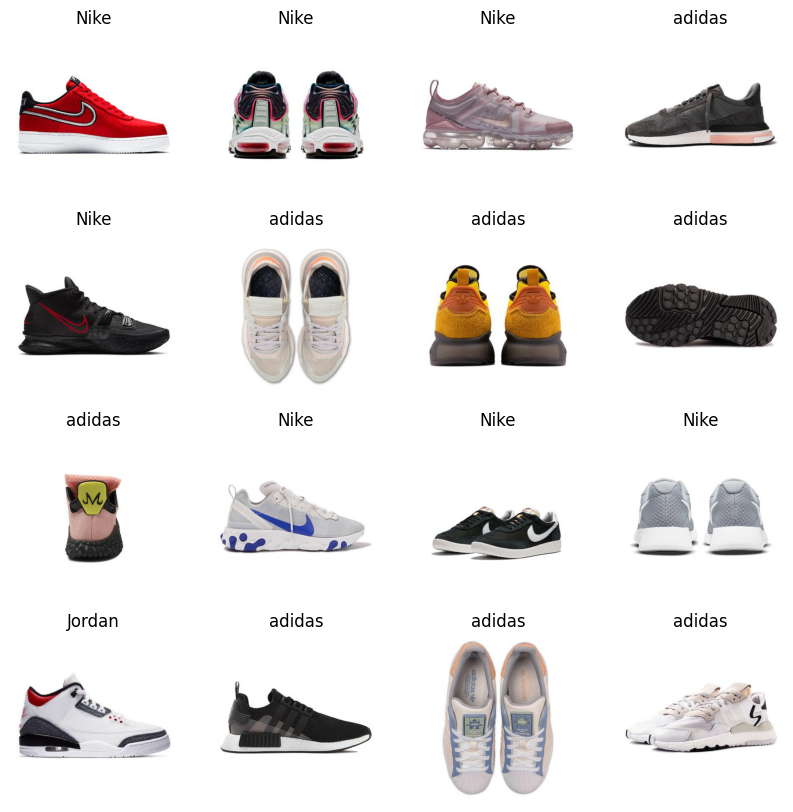

In [21]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        img, brand = images[np.random.randint(len(images))]
        ax[i, j].imshow(np.array(img))
        ax[i, j].set_title(brand)
        ax[i, j].axis("off")
plt.show()

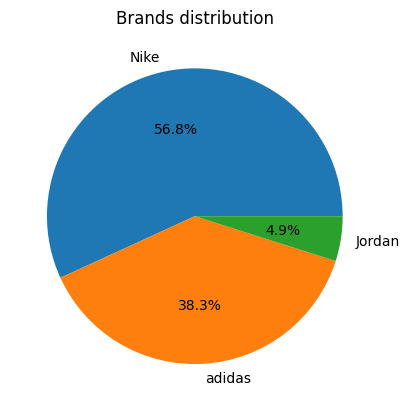

In [24]:
#labels distribution
brands = labels["brand"].value_counts()
plt.pie(brands, labels=brands.index, autopct='%1.1f%%')
plt.title("Brands distribution")
plt.show()

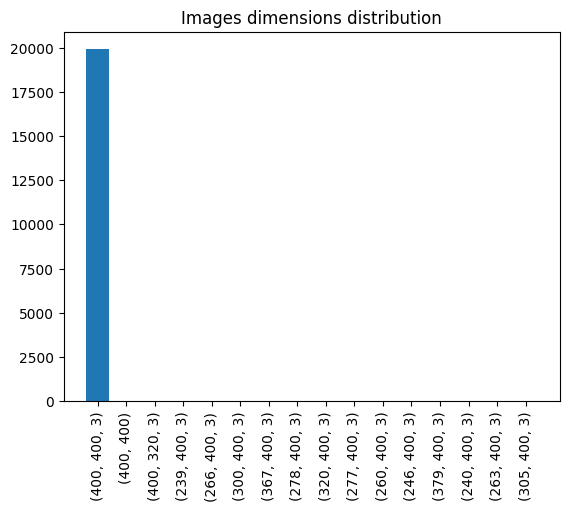

In [25]:
sizes = np.array([str(img.shape) for img, _ in images])
sizes = pd.Series(sizes).value_counts()
plt.bar(sizes.index, sizes.values)
plt.xticks(rotation=90)
plt.title("Images dimensions distribution")
plt.show()

## 3 - Data Preprocessing

##### First, we isolate X and y

In [32]:
X = [img for img, _ in images]
y = [brand for _, brand in images]

##### Resize images 

In [34]:
X = [np.array(Image.fromarray(img).resize((400, 400))) for img in X]

##### We normalize images

In [35]:
X = [img / 255 for img in X]

MemoryError: Unable to allocate 3.66 MiB for an array with shape (400, 400, 3) and data type float64

##### Split the data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# X_train = torch.tensor(X_train)
# X_test = torch.tensor(X_test)
# y_train = torch.tensor(y_train)
# y_test = torch.tensor(y_test)

C:\Users\orteg\AppData\Local\Temp\ipykernel_1736\1807358988.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_train = torch.tensor(X_train)


ValueError: expected sequence of length 400 at dim 1 (got 278)

In [29]:
#are all images the same dimensions?    
print("All images have the same dimensions:", all([img.shape == X[0].shape for img in X]))

All images have the same dimensions: False


## 4 - Prediction

In [24]:
#load a pretrained model for image classification
model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in zip(X_test, y_test):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

Using cache found in C:\Users\orteg/.cache\torch\hub\pytorch_vision_main


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
